In [1]:
import sys
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid", palette="viridis")

sys.path.append(str(Path().resolve().parent / "src"))
from utils import load_all_csvs
from sanitize import sanitize_all
from aggregations import (
    exam_volume_by_zip,
    avg_cost_by_zip,
    exam_volume_by_age_group,
    top_coditems,
    add_age_column
)
from viz_aggregations import (
    plot_exam_volume_by_zip,
    plot_avg_cost_by_zip,
    plot_exam_volume_by_age_group,
    plot_top_coditems
)


In [2]:
dfs = load_all_csvs(Path.cwd().parent / "data")
dfs = sanitize_all(dfs)

In [3]:
for name in dfs:
    dfs[name] = dfs[name].loc[:, ~dfs[name].columns.str.startswith('Unnamed')]

In [4]:
def plot_numeric_distributions(dfs: dict[str, pd.DataFrame], max_cols: int = 3, bins: int = 50):
    ignore_keywords = ['id', 'zipcode', 'coditem', 'zip', 'lab']

    for name, df in dfs.items():
        # Seleciona colunas numéricas e remove identificadores
        num_df = df.select_dtypes(include='number')
        cols_to_plot = [col for col in num_df.columns if not any(k in col.lower() for k in ignore_keywords)]
        if not cols_to_plot:
            continue

        print(f"\n📊 Distribuições numéricas – {name}")
        n_cols = len(cols_to_plot)
        n_rows = (n_cols + max_cols - 1) // max_cols

        fig, axes = plt.subplots(n_rows, min(n_cols, max_cols), figsize=(5 * max_cols, 4 * n_rows))
        axes = axes.flatten() if n_cols > 1 else [axes]

        for i, col in enumerate(cols_to_plot):
            sns.histplot(data=df, x=col, bins=bins, ax=axes[i], kde=True)
            axes[i].set_title(col)
            axes[i].set_xlabel("")
            axes[i].set_ylabel("")

        for j in range(i + 1, len(axes)):
            axes[j].set_visible(False)

        plt.tight_layout()
        plt.show()


📊 Distribuições numéricas – exams


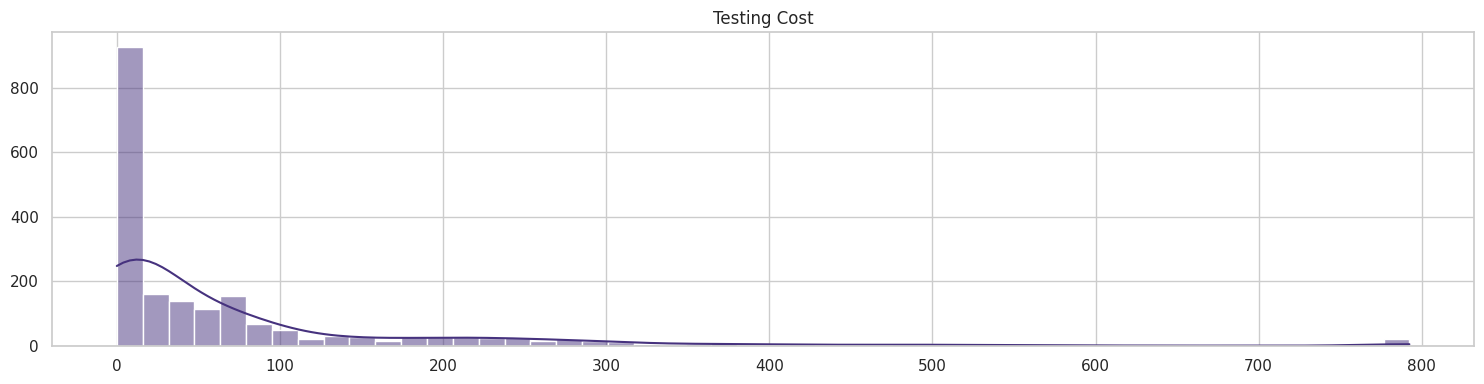


📊 Distribuições numéricas – demographic


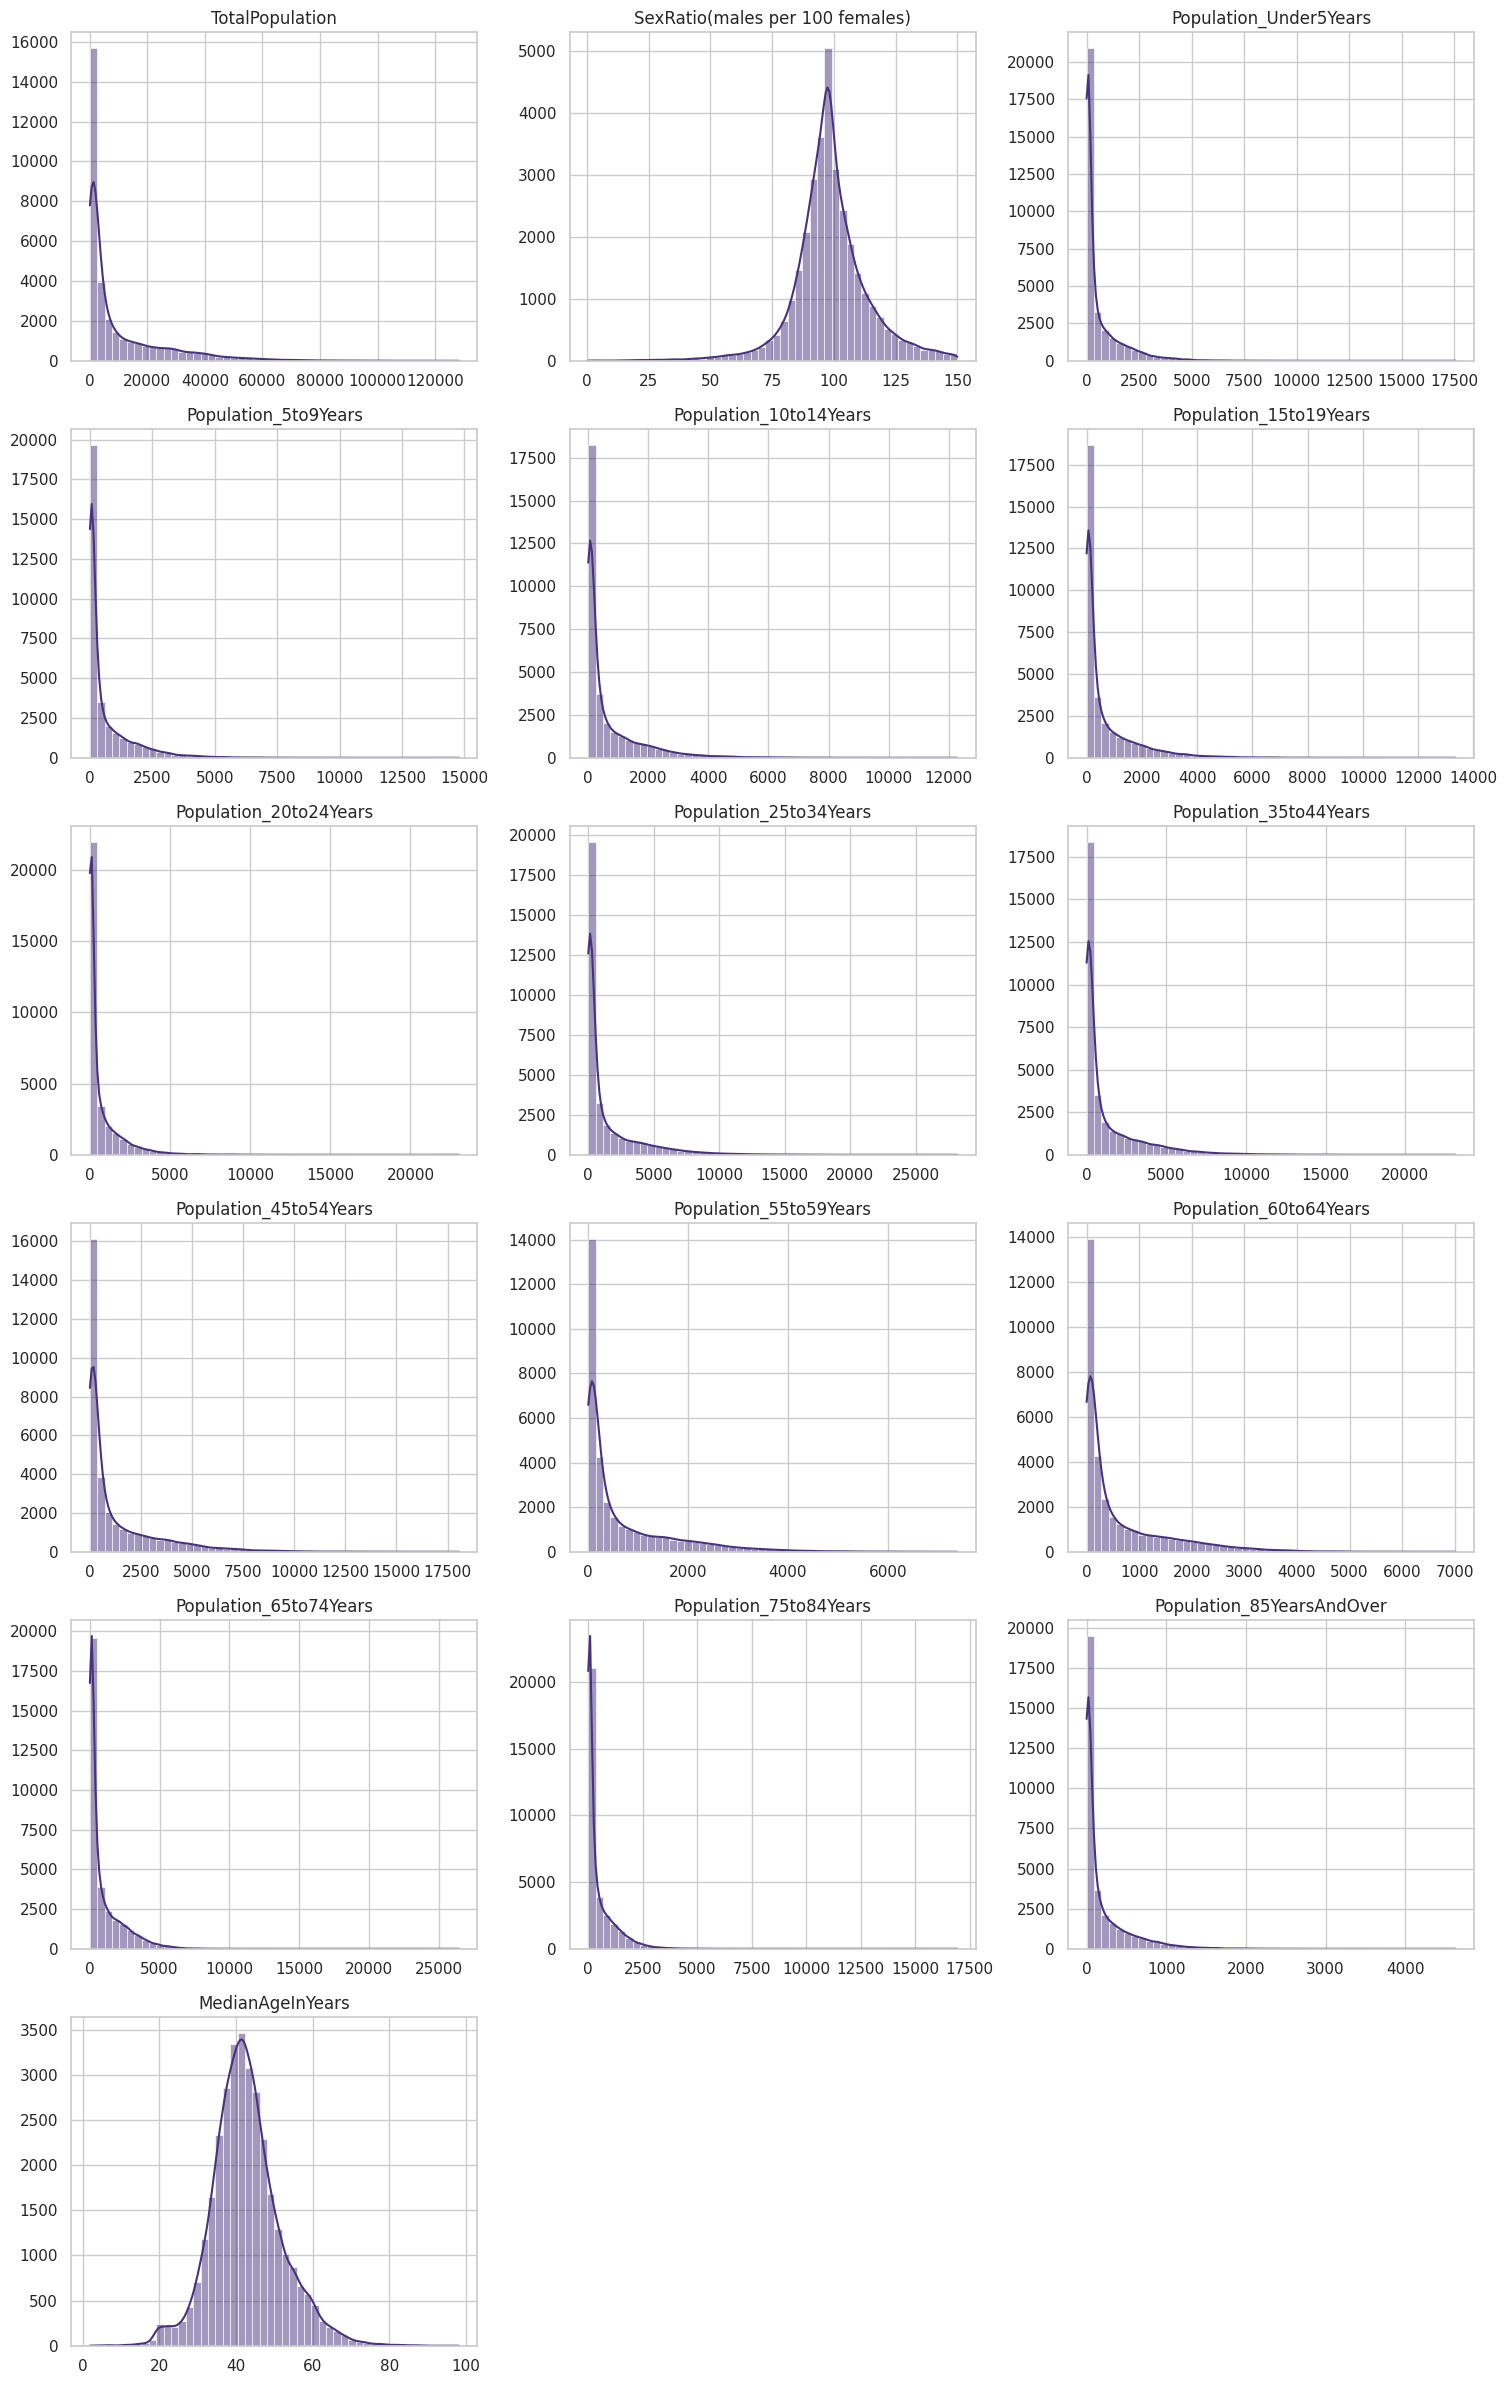


📊 Distribuições numéricas – transactional


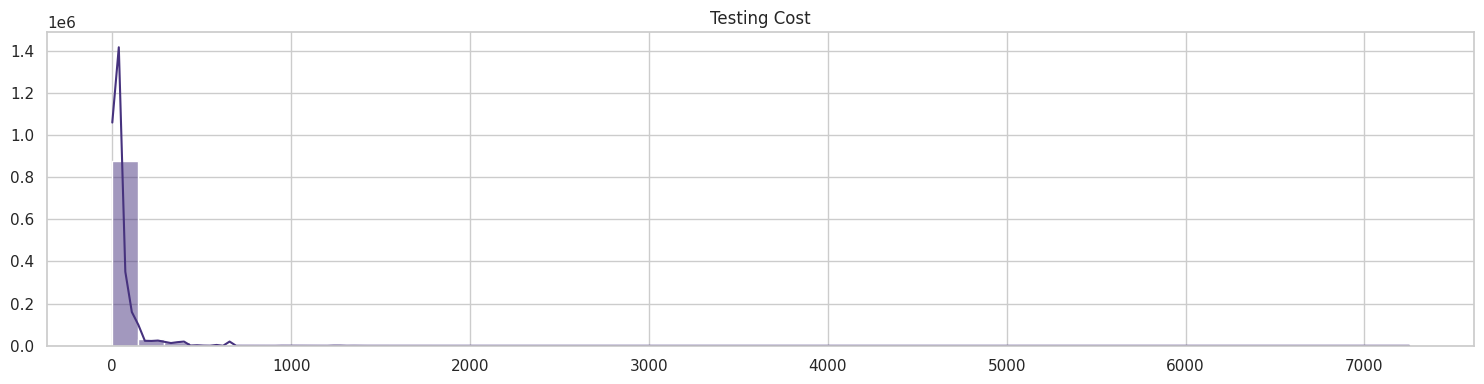


📊 Distribuições numéricas – economic


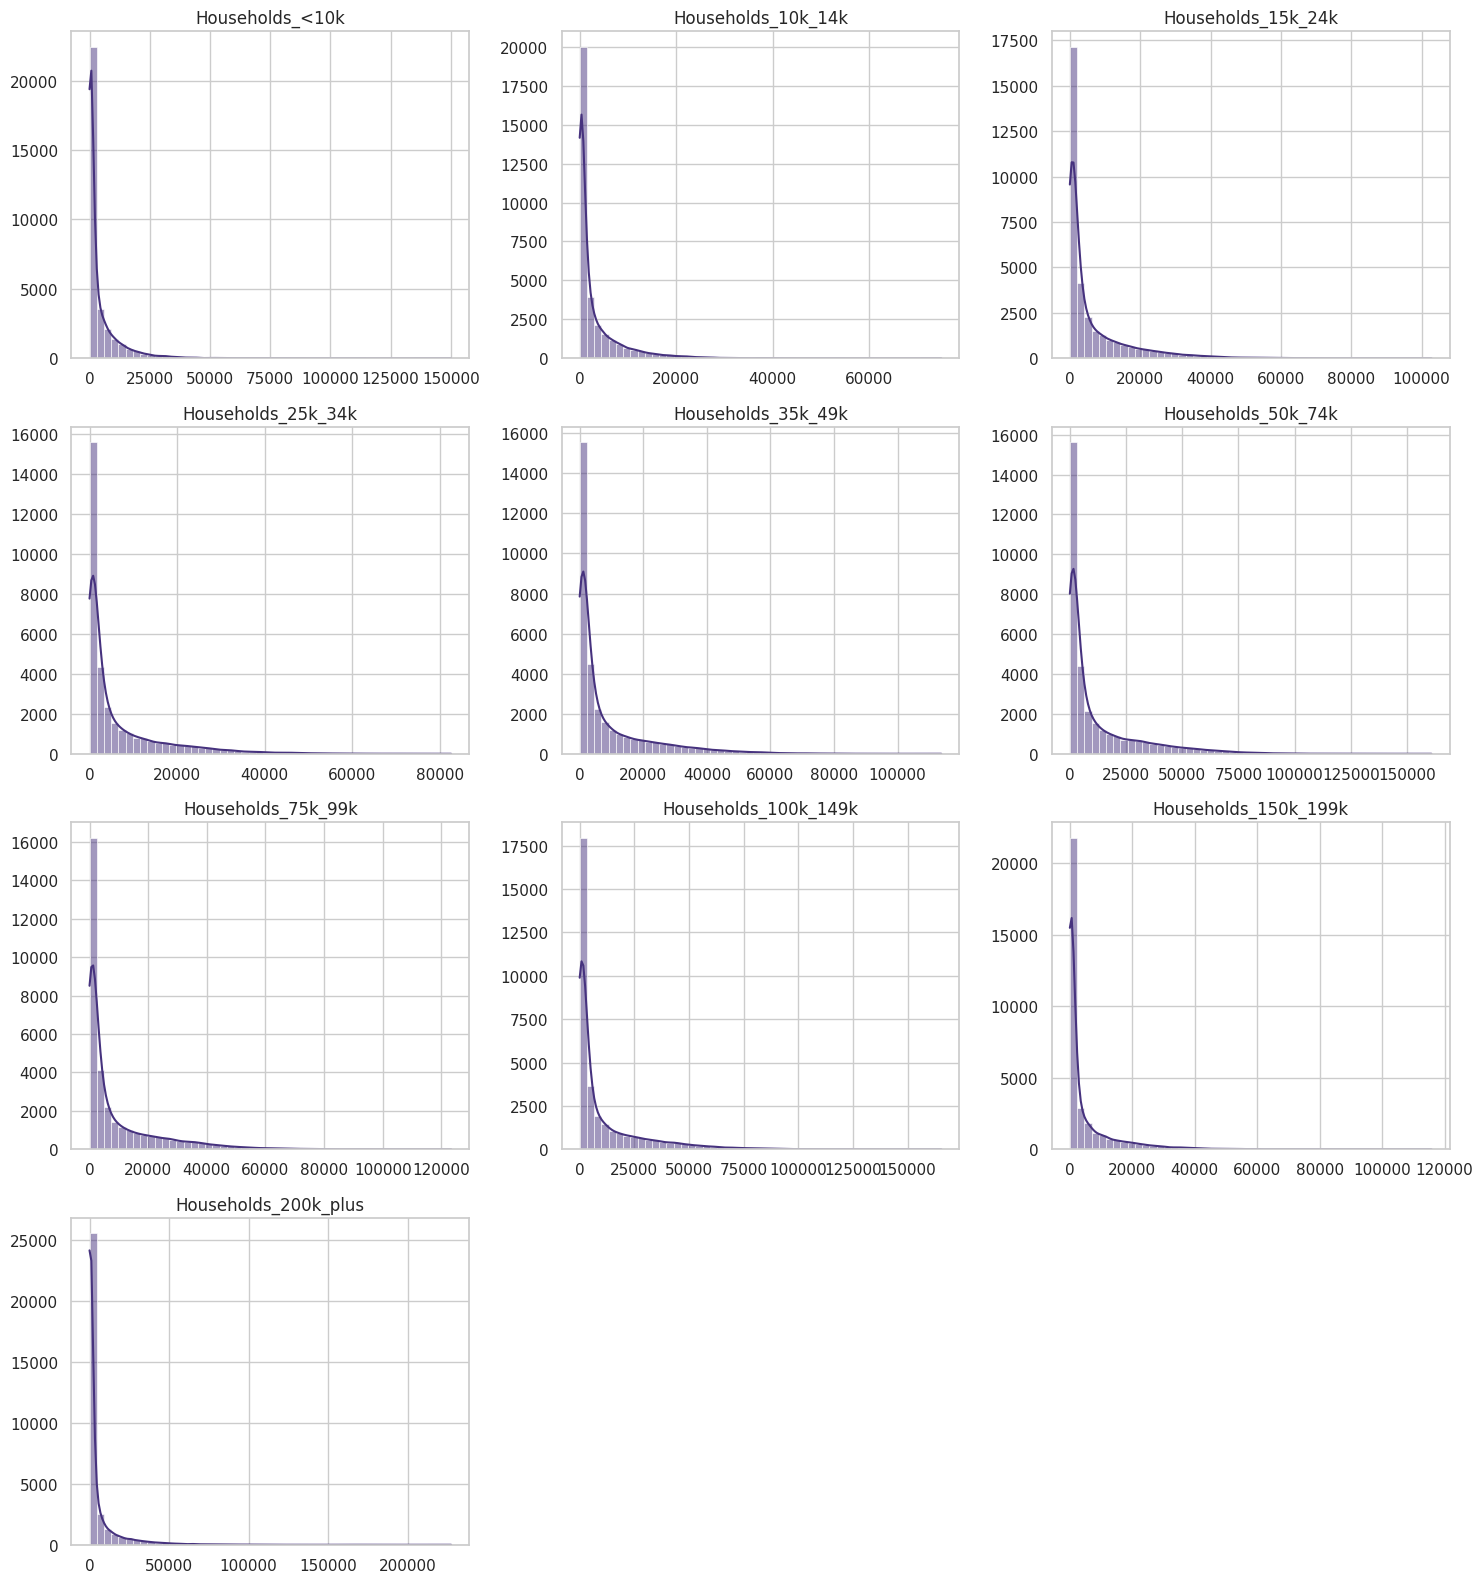

In [5]:
plot_numeric_distributions(dfs)

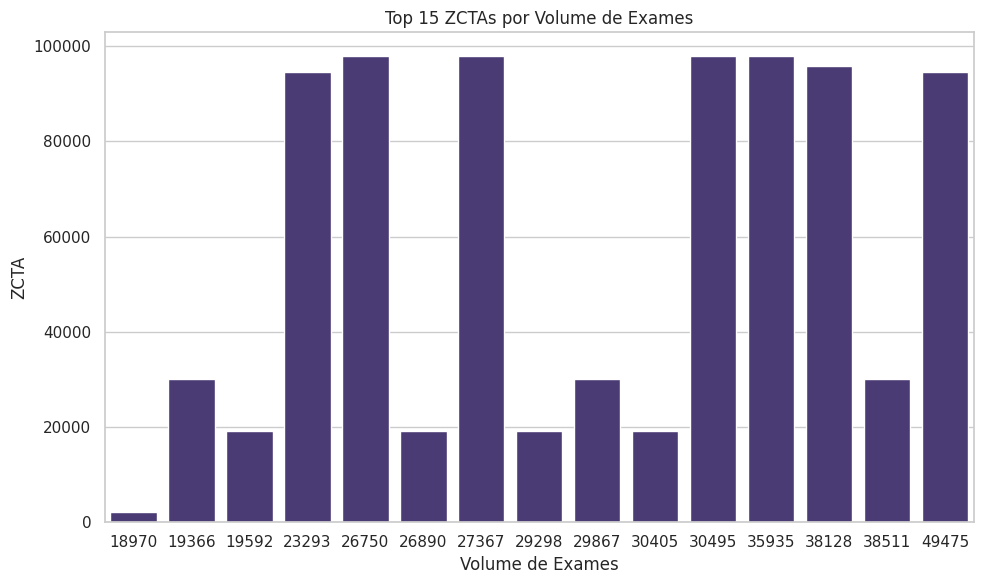

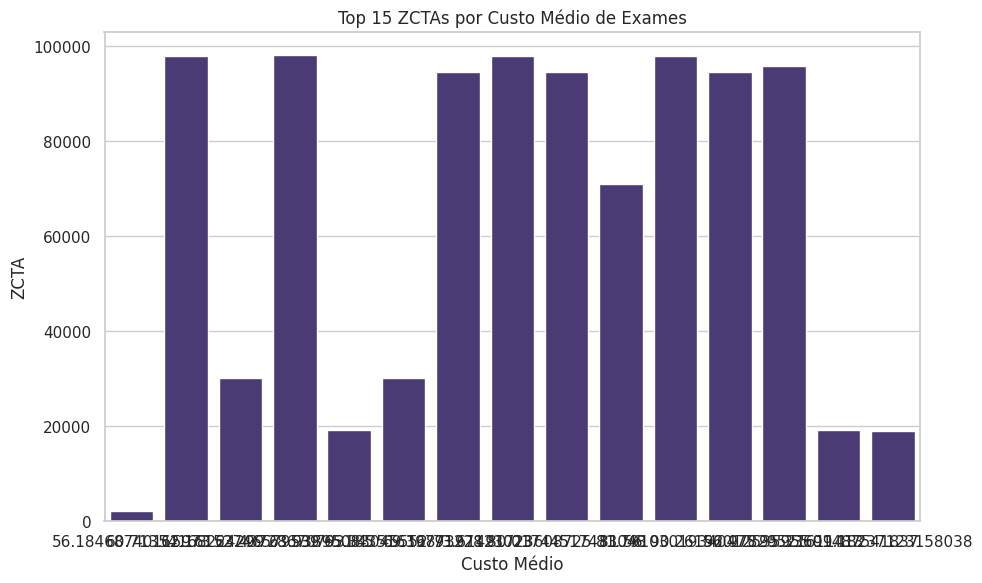

/app/src/aggregations.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return df.groupby(faixa)['Patient Id'].count()


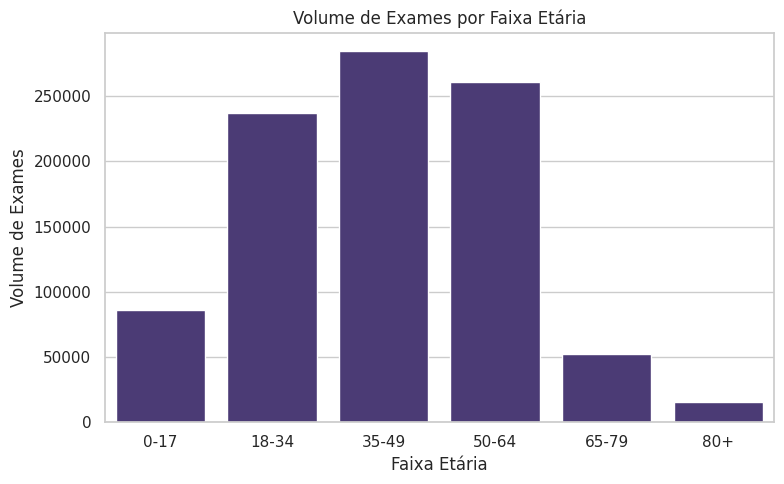

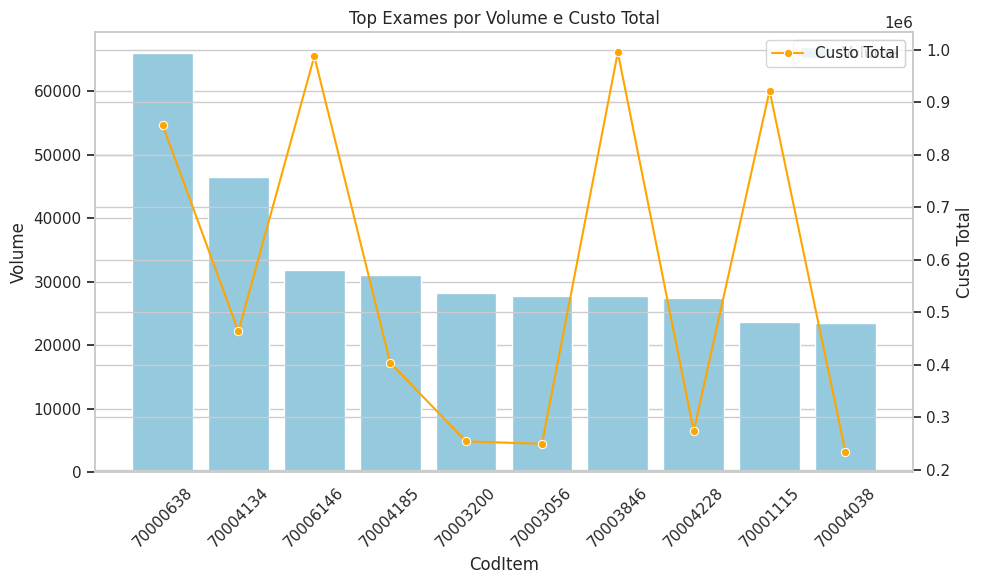

In [6]:
transactional = dfs['transactional']
geocode = dfs['geocode']

# Exam volume by ZCTA
volume_zip = exam_volume_by_zip(transactional, geocode)
plot_exam_volume_by_zip(volume_zip)

# Average testing cost by ZCTA
custo_zip = avg_cost_by_zip(transactional, geocode)
plot_avg_cost_by_zip(custo_zip)

# Exam volume by age group
transactional = add_age_column(transactional)
volume_faixa = exam_volume_by_age_group(transactional)
plot_exam_volume_by_age_group(volume_faixa)

# Top CodItems by volume and total cost
top_cod = top_coditems(transactional)
plot_top_coditems(top_cod)
